# Read the data into a pandas dataframe, which is basically an excell spreadsheet. The features of this dataset are included in the list "all_features"

In [42]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


path = ""
file = 'wisconsin.csv'
path_to_file = path+file


df = pd.read_csv(path_to_file, sep=',')


all_features = ['radius_mean','texture_mean','perimeter_mean', 'area_mean', 'smoothness_mean', 
            'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
            'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
            'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se','fractal_dimension_se', 'radius_worst', 
            'texture_worst', 'perimeter_worst','area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 
            'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


# Our initial learning curve using a basic support vector classifier (SVC)

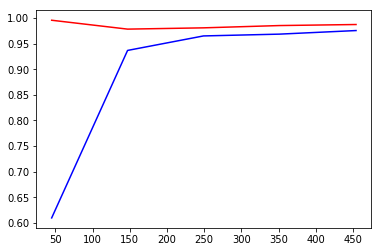

In [39]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.svm import SVC


X = df[all_features] # dataset of features describing malignant and benign tumours
y = df['diagnosis'] # corresponding labels which denote whether the tumour is malignant or benign

#we need to first scale the data so that all values are on the same order of magnitude to each other.
# not scaling the data has a huge hit to performance.
scaler = StandardScaler()
X = scaler.fit_transform(X)

#define our model, the default uses an 'rbf' kernel which is what we like to use.
model=SVC()

cv=5 #define the numnber of cross-validations to perform

#this makes a learning curve! and outputs the accuracy for each cross-validation iteration, for each amount of data included
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv) 

mean_train_score = np.mean(train_scores,axis=1) #take the average mean accuracy for each size of training data
mean_test_score = np.mean(test_scores,axis=1)


#plot an x,y,colour=, graph.
plt.plot(train_sizes, mean_train_score, c='r')
plt.plot(train_sizes, mean_test_score, c='b')
plt.show() #show the graph in the console


# Our first grid search to try and improve upon our initial learning curve..

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split


X = df[all_features]
y = df['diagnosis']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# this is only necessary if you want to be super conservative...
# we are reserving 20% of the data as a true test set, and then will perform cross-validation on the train set.
#note, random state 42 is kind of just a joke number... pick whatever random seed number you like.. its just to ensure replicability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#setting up our grid range to iterate through parameter choices
C_range = [0.01,0.1,1,2,5,10]
gamma_range = [0.01,0.05,0.1,0.25,0.5]

#construct a dictionary to define the parameter ranges
param_grid = dict(gamma=gamma_range,C=C_range)
print(param_grid)

#define our cross-validation splits
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
#choose a base model (corresponding to the parameters we are going to iterate)
svc = SVC()
#setup our gridsearch using the mode, the parameter dictionary, the cross-validation instructions
grid = GridSearchCV(svc, param_grid=param_grid, cv=cv) #default cross validation is 3-fold
#... grid setup

print('...running grid search...')
#fit the grid model with our data
grid.fit(X_train,y_train) #replace with grid.fit(X,y) if you do not want to reserve a test set
best_params = grid.best_params_ #best parameters
best_score = grid.best_score_ #best corresponding score

print(f'best parameters: {best_params}\nbest score: {best_score}')

{'gamma': [0.01, 0.05, 0.1, 0.25, 0.5], 'C': [0.01, 0.1, 1, 2, 5, 10]}
...running grid search...
best parameters: {'C': 1, 'gamma': 0.01}
best score: 0.9758241758241758


In [73]:
#test on test set with best params
from sklearn.metrics import accuracy_score

svc = SVC(C=2,gamma=0.01)
svc.fit(X_train,y_train)

y_pred = svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"test set accuracy: {accuracy}")

test set accuracy: 0.9824561403508771


# post grid search learning curve

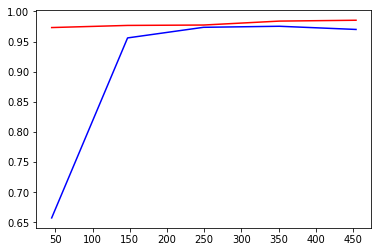

In [74]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.svm import SVC

cv=5
X = df[all_features]
y = df['diagnosis']

scaler = StandardScaler()
X = scaler.fit_transform(X)

model=SVC(C=2,gamma=0.01) 

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv)

mean_train_score = np.mean(train_scores,axis=1)
mean_test_score = np.mean(test_scores,axis=1)


plt.plot(train_sizes, mean_train_score, c='r')
plt.plot(train_sizes, mean_test_score, c='b')
plt.show()

# Lets try and reduce the number of features to see if we can improve accuracy

In [76]:
#lets reduce features with PCA

X = df[all_features]
y = df['diagnosis']
#y = df['diagnosis']

scaler = StandardScaler()
X = scaler.fit_transform(X)


nPCs = 16   #choose the number of PCs, ideally, find the number whereby >99% of variance is retained
pca = PCA(n_components=nPCs) #create the PCA model with predefined paramters

X = pca.fit_transform(X) # PCA transform our data

print(pca.explained_variance_ratio_) #explained variance
print(f"nfeatures: {len(all_features)}, nPCs: {nPCs} explains {np.sum(pca.explained_variance_ratio_)} of total variance")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #random state 42 is kind of just a joke number.. pick whatever seed you like

#REDO THE GRID SEARCH USING PCA TRANSFORMED DATA

#setting up our grid range...
C_range = [0.01,0.1,1,2,5,10]
gamma_range = [0.01,0.05,0.1,0.25,0.5]

param_grid = dict(gamma=gamma_range,C=C_range)
print(param_grid)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
svc = SVC()
grid = GridSearchCV(svc, param_grid=param_grid, cv=cv)
#... grid setup

print('...running grid search...')
grid.fit(X_train,y_train) #replace with grid.fit(X,y) if you do not want to reserve a test set
best_params = grid.best_params_
best_score = grid.best_score_

print(f'best parameters: {best_params}\nbest score: {best_score}')


[0.44272026 0.18971182 0.09393163 0.06602135 0.05495768 0.04024522
 0.02250734 0.01588724 0.01389649 0.01168978 0.00979719 0.00870538
 0.00804525 0.00523366 0.00313783 0.00266209]
nfeatures: 30, nPCs: 16 explains 0.9891502160765598 of total variance
{'gamma': [0.01, 0.05, 0.1, 0.25, 0.5], 'C': [0.01, 0.1, 1, 2, 5, 10]}
...running grid search...
best parameters: {'C': 1, 'gamma': 0.05}
best score: 0.978021978021978


In [77]:
from sklearn.metrics import accuracy_score

svc = SVC(C=2,gamma=0.01)
svc.fit(X_train,y_train)

y_pred = svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"test set accuracy: {accuracy}")

test set accuracy: 0.9824561403508771


# Lets try to select the individual 10 most predictive feature combinations and see if this improves accuracy

In [89]:
from sklearn.feature_selection import RFE

X = df[all_features]
y = df['diagnosis']

scaler = StandardScaler()
X = scaler.fit_transform(X)

model = SVC(C=2,kernel='linear') # for some reason RFE doesn't work with RBF kernels...


#setup the RFE model with its parameters...
rfe = RFE(model, n_features_to_select=10, step=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#fit the RFE model
rfe.fit(X_train, y_train)
ranking = rfe.ranking_ #ranking of input features, the top number will all appear with a 1

print(ranking)

# some messy code to return a list of the top features from the initial list
feature_rankings = np.where(ranking == 1)

top_features = list(np.array(all_features)[feature_rankings])
print(top_features)


[12 17 19 21 18  1  4  1  7 14  1 11 16  1  3  6 10 15  1  2  1  1 13  1
 20  9  1  8  1  5]
['compactness_mean', 'concave points_mean', 'radius_se', 'area_se', 'symmetry_se', 'radius_worst', 'texture_worst', 'area_worst', 'concavity_worst', 'symmetry_worst']


In [90]:
## repeat the procedure with the best features!
X = df[top_features]
y = df['diagnosis']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = SVC(C=2, gamma=0.1, kernel='rbf') #default kernel
model.fit(X_train,y_train)

print(f"train accuracy, {model.score(X_train,y_train)}")

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"test set accuracy: {accuracy}")

train accuracy, 0.9824175824175824
test set accuracy: 0.9473684210526315


# A note about using standard scaler and PCA... you might be applying your model to not a dataset.. but new novel values, how do we scale and PCA transform new data??

In [95]:
X = df[all_features]
y = df['diagnosis']

scaler = StandardScaler()
pca = PCA(n_components=16) #uses as many components as features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = scaler.fit(X_train)

print(X_train.head())
X_train = scaler.transform(X_train)
print(X_train)
X_test = scaler.transform(X_test) #transforms using the parameters learned from the training dataset
print(X_test)

X_train = pca.fit_transform(X_train) #transforms using the parameters learned from the training dataset
X_test = pca.transform(X_test)

print(X_test)


#in summary.. save the scaler and pca models, and use them to transform subsequent data you see, so all data which feeds into 
# the model is transformed in the same way and is therefore equivalent.


     radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
68         9.029         17.33           58.79      250.5          0.10660   
181       21.090         26.57          142.70     1311.0          0.11410   
63         9.173         13.86           59.20      260.9          0.07721   
248       10.650         25.22           68.01      347.0          0.09657   
60        10.170         14.88           64.55      311.9          0.11340   

     compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
68            0.14130         0.31300              0.04375         0.2111   
181           0.28320         0.24870              0.14960         0.2395   
63            0.08751         0.05988              0.02180         0.2341   
248           0.07234         0.02379              0.01615         0.1897   
60            0.08061         0.01084              0.01290         0.2743   

     fractal_dimension_mean           ...             radius_worst  